# Paddy Disease Identification - Classifier 
[참고 노트북 | Paddy Disease, PyTorch (acc=98.0%)](https://www.kaggle.com/code/konradszafer/paddy-disease-pytorch-acc-98-0)  
파이토치를 배우기 시작해 기존에 사용하던 텐서플로가 아니라 파이토치로 필사를 진행  

### 사용 라이브러리

In [3]:
import os
from os import walk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm

In [5]:
params = {
    'epochs': 25,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'momentum': 0.9,
    'test_size': 0.05,
    'seed': 1
}

In [14]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data Load

In [6]:
dataset_dir = "./data/train_images/"
submission_dir = "./data/test_images/"
dataset_file = "./data/train.csv"
submission_sample = "./data/sample_submission.csv"

df = pd.read_csv(dataset_file)
df = shuffle(df, random_state=params["seed"])

print(f"count: {len(df)}")
df.head()

count: 10407


,image_id,label,variety,age
8845,107872.jpg,normal,ADT45,70
8148,105537.jpg,normal,ADT45,60
5701,105132.jpg,downy_mildew,AtchayaPonni,45
9601,105680.jpg,tungro,ADT45,60
3649,102240.jpg,brown_spot,ADT45,72


### Label Encoding

In [7]:
idx_to_label = df['label'].unique()
label_to_idx = {idx: label for label, idx in enumerate(idx_to_label)}
print(label_to_idx)

{'normal': 0, 'downy_mildew': 1, 'tungro': 2, 'brown_spot': 3, 'blast': 4, 'bacterial_leaf_streak': 5, 'bacterial_leaf_blight': 6, 'hispa': 7, 'dead_heart': 8, 'bacterial_panicle_blight': 9}


### Data Split

In [8]:
train_df, test_df = train_test_split(df, test_size=params['test_size'])

print(f'train len: {len(train_df)}, test len: {len(test_df)}')

train len: 9886, test len: 521


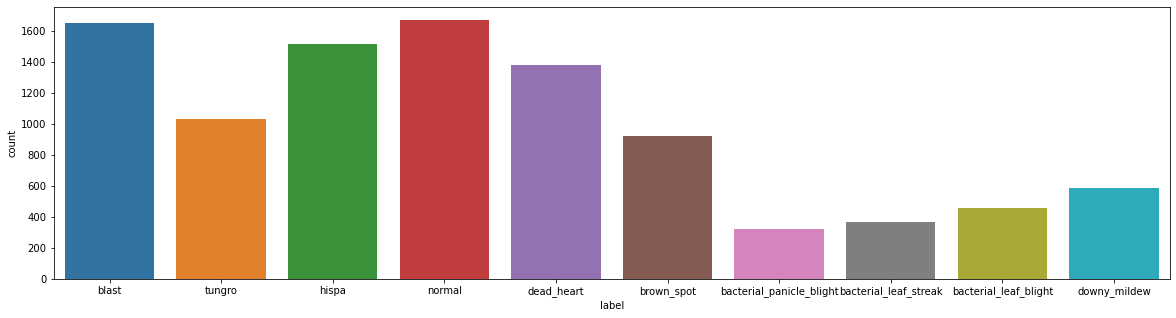

In [9]:
plt.figure(figsize=(20, 5))
_ = sns.countplot(data=train_df, x="label")

### Data Augumentation

In [10]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomChoice([
        transforms.Pad(padding=10),
        transforms.CenterCrop(480),
        transforms.RandomRotation(20),
        transforms.CenterCrop((576,432)),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1, 
            saturation=0.1,
            hue=0.1
        )
    ]),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### PyTorch Dataset

In [11]:
class PaddyDataset(Dataset):
    def __init__(self, dataset_dir, df, label_to_idx, transforms):
        self.df = df
        self.label_to_idx = label_to_idx
        self.transforms = transforms
        self.df['path'] = dataset_dir + '/' + self.df.label + '/' + self.df.image_id
        # 0: image_id, 1: label, 2: variety, 3: age, 4: path
        self.df = self.df.values.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        image = Image.open(row[4])
        image = self.transforms(image)
        idx = self.label_to_idx[row[1]]
        return image, idx

In [12]:
train_dataset = PaddyDataset(dataset_dir, train_df, label_to_idx, train_transform)
test_dataset = PaddyDataset(dataset_dir, test_df, label_to_idx, test_transform)
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True, pin_memory=True)

### Model

In [15]:
model = models.resnet34(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, len(label_to_idx))
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

c:\Users\spec3\anaconda3\envs\Deep\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\spec3\anaconda3\envs\Deep\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train

In [16]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):

    total_train_loss = 0
    total_test_loss = 0
    
    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss / len(train_dataset)
    test_acc = total_test_loss / len(test_dataset)
    print(f'Train loss: {train_acc:.4f} Test loss: {test_acc:.4f} ')

In [17]:
%%time
for i in range(params['epochs']):
    print(f"Epoch {i+1}/{params['epochs']}")
    train(model, criterion, optimizer, train_dataloader, test_dataloader)

Epoch 1/25


Train loss: 0.0405 Test loss: 0.0250 
Epoch 2/25


Train loss: 0.0202 Test loss: 0.0166 
Epoch 3/25


Train loss: 0.0137 Test loss: 0.0116 
Epoch 4/25


Train loss: 0.0102 Test loss: 0.0099 
Epoch 5/25


Train loss: 0.0084 Test loss: 0.0084 
Epoch 6/25


Train loss: 0.0065 Test loss: 0.0072 
Epoch 7/25


Train loss: 0.0054 Test loss: 0.0068 
Epoch 8/25


Train loss: 0.0047 Test loss: 0.0064 
Epoch 9/25


Train loss: 0.0042 Test loss: 0.0051 
Epoch 10/25


Train loss: 0.0038 Test loss: 0.0053 
Epoch 11/25


Train loss: 0.0036 Test loss: 0.0050 
Epoch 12/25


Train loss: 0.0032 Test loss: 0.0050 
Epoch 13/25


Train loss: 0.0027 Test loss: 0.0052 
Epoch 14/25


Train loss: 0.0025 Test loss: 0.0055 
Epoch 15/25


Train loss: 0.0024 Test loss: 0.0060 
Epoch 16/25


Train loss: 0.0020 Test loss: 0.0060 
Epoch 17/25


Train loss: 0.0022 Test loss: 0.0043 
Epoch 18/25


Train loss: 0.0019 Test loss: 0.0053 
Epoch 19/25


Train loss: 0.0018 Test loss: 0.0046 
Epoch 20/25


Train loss: 0.0017 Test loss: 0.0044 
Epoch 21/25


Train loss: 0.0016 Test loss: 0.0049 
Epoch 22/25


Train loss: 0.0017 Test loss: 0.0048 
Epoch 23/25


Train loss: 0.0017 Test loss: 0.0068 
Epoch 24/25


Train loss: 0.0014 Test loss: 0.0051 
Epoch 25/25


Train loss: 0.0012 Test loss: 0.0040 
CPU times: total: 6h 7min 43s
Wall time: 1h 2min 26s


### Evaluation

In [18]:
%%time
model.eval()
image_ids, labels = [], []
for (dirpath, dirname, filenames) in walk(submission_dir):
    for filename in filenames:
        image = Image.open(dirpath+filename)
        image = test_transform(image)
        image = image.unsqueeze(0).to(device)
        image_ids.append(filename)
        labels.append(idx_to_label[model(image).argmax().item()])

CPU times: total: 6min 33s
Wall time: 1min 9s


### Submission

In [21]:
sub = pd.DataFrame({
    'image_id': image_ids,
    'label': labels,
})

sub.to_csv("sub_torch.csv", index=False)

### 마무리
파이토치.. 너무 어렵다..  
텐서가 keras를 이용해 추상화가 잘 되어있어 코드가 굉장히 간편하다는 사실을 알았다.  
토치를 공부하기 시작한 이유가 좀 더 세세한 튜닝에 용이하고 점유율이 좀 더 높아서 인데, 토치도 자주 사용하면서 익숙해지려고 노력해야할꺼 같다  